### Import

In [1]:
import copy
import datetime
import joblib
from collections import defaultdict
from tqdm import tqdm; tqdm.pandas()
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import LogScaler, NoneScaler, CustomLabelEncoder

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
test_mode = False

# Raw data
is_raw_data_exist = True
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 365
PRED_LEN = 100
modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "others": ["sales_channel_id", "prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]
}
processing_info = {
    "scaling_cols": {"sales": LogScaler, "price": MinMaxScaler},
    "embedding_cols": ["sales_channel_id", "day", "dow", "month", "holiday",
                        "prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"],
    "img_cols": ["img_path"]
}


modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": [],
    "others": ["sales_channel_id"]
}
processing_info = {
    "scaling_cols": {"sales": LogScaler, "price": MinMaxScaler},
    "embedding_cols": ["sales_channel_id", "day", "dow", "month", "holiday"],
    "img_cols": []
}


# Model
batch_size = 32
target_batch_size = 128
grad_accm_step_max = target_batch_size // batch_size

d_model = {"encoder":64, "decoder":32}
nhead = 4
d_ff = {"encoder":128, "decoder":64}
dropout = 0.1
num_layers = {"encoder":4, "decoder":2}

remain_rto = {"target": 0.25, "temporal":0.25, "cat":1}

patch_size = 14

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data(is_raw_data_exist=True)
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]

data_info = DataInfo(modality_info, processing_info)

{'group': ['article_id', 'sales_channel_id'], 'target': ['sales'], 'temporal': ['day', 'dow', 'month', 'holiday', 'price'], 'img': [], 'others': ['sales_channel_id']}


In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto["target"], remain_rto["temporal"])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

valid_dataset = Dataset(df_valid, data_info, remain_rto["target"], remain_rto["temporal"], is_train=False, label_encoder_dict=train_dataset.label_encoder_dict)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True)

if True:
    for data in train_dataloader:
        for key in data.keys():
            if "img_raw" not in key:
                print(key, data[key].shape)
        break

    # for _ in valid_dataloader:
    #     break

100%|██████████| 29388/29388 [00:01<00:00, 21315.41it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales torch.Size([32, 365, 1])
sales_remain_idx torch.Size([32, 91])
sales_masked_idx torch.Size([32, 274])
sales_revert_idx torch.Size([32, 365])
sales_remain_padding_mask torch.Size([32, 91])
sales_masked_padding_mask torch.Size([32, 274])
sales_revert_padding_mask torch.Size([32, 365])
day torch.Size([32, 365])
day_remain_idx torch.Size([32, 91])
day_masked_idx torch.Size([32, 274])
day_revert_idx torch.Size([32, 365])
day_remain_padding_mask torch.Size([32, 91])
day_masked_padding_mask torch.Size([32, 274])
day_revert_padding_mask torch.Size([32, 365])
dow torch.Size([32, 365])
dow_remain_idx torch.Size([32, 91])
dow_masked_idx torch.Size([32, 274])
dow_revert_idx torch.Size([32, 365])
dow_remain_padding_mask torch.Size([32, 91])
dow_masked_padding_mask torch.Size([32, 274])
dow_revert_padding_mask torch.Size([32, 365])
month torch.Size([32, 365])
month_remain_idx torch.Size([32, 91])
month_masked_idx torch.Size([32, 274])
month_revert_idx torch.Size([32, 365])
month_remain_padding

# Train

### Model

In [6]:
from architecture import Transformer

model = Transformer(data_info, train_dataset.label_encoder_dict, patch_size,
                        d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

-----------------------------------------------------------------------------------------------------------
   Parent Layers       Layer (type)                            Output Shape         Param #     Tr. Param #
     Transformer        Embedding-1                                 [2, 64]             128             128
     Transformer     OthersRemain-2                             [32, 2, 64]              64              64
     Transformer        Embedding-3                             [32, 2, 64]             448             448
     Transformer          Encoder-4        [32, 554, 64], [32, 4, 554, 554]         133,888         133,888
     Transformer           Linear-5                           [32, 554, 32]           2,080           2,080
     Transformer        Embedding-6                                 [2, 32]              64              64
     Transformer     OthersRevert-7                             [32, 2, 32]              32              32
     Transformer        Embe

'-----------------------------------------------------------------------------------------------------------\n   Parent Layers       Layer (type)                            Output Shape         Param #     Tr. Param #\n===========================================================================================================\n     Transformer        Embedding-1                                 [2, 64]             128             128\n     Transformer     OthersRemain-2                             [32, 2, 64]              64              64\n     Transformer        Embedding-3                             [32, 2, 64]             448             448\n     Transformer          Encoder-4        [32, 554, 64], [32, 4, 554, 554]         133,888         133,888\n     Transformer           Linear-5                           [32, 554, 32]           2,080           2,080\n     Transformer        Embedding-6                                 [2, 32]              64              64\n     Transformer  

### Train

sales_channel_id - 	 y: 2.0 	 pred:2.0


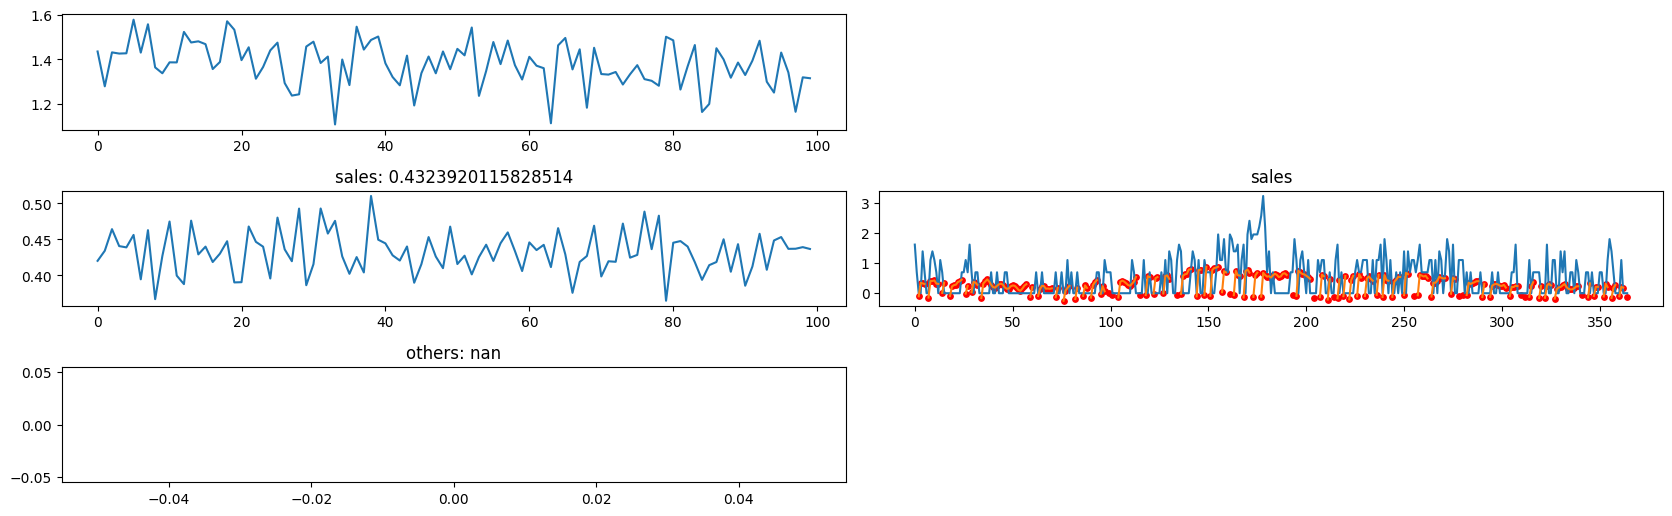

3 - loss: 1.37456334233284, lr: [0.00099778098230154]:  91%|█████████ | 832/919 [02:37<00:16,  5.41it/s]  

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
# mse_loss = torch.nn.MSELoss(reduction="none")
mse_loss = torch.nn.L1Loss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
max_norm = 1

def temporal_loss(col, pred, y, masked_idx, padding_mask=None):
    masked_idx = masked_idx.to(device)
    padding_mask = padding_mask.to(device)
    
    if col in data_info.processing_info["scaling_cols"]:
        pred = pred[:, 1:, :].squeeze()
        pred = torch.gather(pred, index=masked_idx, dim=1)
        
        y = y.squeeze().to(device)
        y = torch.gather(y, index=masked_idx, dim=1)

        loss = mse_loss(pred, y)
        loss = torch.where(padding_mask == 1, loss, 0)
        loss = loss.sum() / padding_mask.sum()
    
    elif col in data_info.processing_info["embedding_cols"]:
        pred_masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        pred = pred[:, 1:, :]
        pred = torch.gather(pred, index=pred_masked_idx, dim=1)

        y = y.to(device).to(torch.long)
        y = torch.gather(y, index=masked_idx, dim=1)

        loss = ce_loss(pred.reshape(-1, pred.shape[-1]), y.reshape(-1))
        loss = loss.view(y.shape)
        loss = torch.where(padding_mask == 1, loss, 0)
        loss = loss.sum() / padding_mask.sum()

    return loss

def others_loss(pred, y):
    loss = ce_loss(pred, y.to(device).to(torch.long))
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    # pbar = tqdm(valid_dataloader)
    loss_li_dict, loss_li, window, grad_accm_step = defaultdict(list), [], 100, 0
    optimizer.zero_grad()

    for n, data in enumerate(pbar):
        model.train()
        output, others_idx_dict = model(data, remain_rto, device)
        loss_dict = {}
        # Temporal loss
        for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            loss  = temporal_loss(col, output[col], data[col], data[f"{col}_masked_idx"], data[f"{col}_masked_padding_mask"])
            loss_dict[col] = loss
            loss_li_dict[col].append(loss.item())
        
        # Ohters loss
        others_loss_li = []
        for col in data_info.modality_info["others"]:
            loss = others_loss(output[col], data[col])
            others_loss_li.append(loss)
        others_loss_li = torch.stack(others_loss_li, dim=1)
        masked_idx = others_idx_dict["others_masked_idx"]
        
        loss = torch.gather(others_loss_li, index=masked_idx, dim=1)
        loss = torch.mean(loss)
        loss_dict["others"] = loss
        loss_li_dict["others"].append(loss.item())
        
        # Sum loss
        loss = torch.nansum(torch.stack(list(loss_dict.values()))) / grad_accm_step_max
        
        loss.backward()
        grad_accm_step += 1

        if grad_accm_step == grad_accm_step_max:
            st = datetime.datetime.now()
            loss_li.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            grad_accm_step = 0
        
        msg = f"{e} - loss: {np.nanmean(loss_li[-window:])}, lr: {scheduler.get_last_lr()}"
        pbar.set_description(msg)
        
        if n % (grad_accm_step_max*20) == 0:
            model.eval()
            with torch.no_grad():
                output, _ = model(data, remain_rto, device)
            idx = 0
            plt.figure(figsize=(25,35))
            nrows, ncols = 20, 3
            plot_idx = 1
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(loss_li[-window:])
            plot_idx += 2

            # Temporal samples
            for col in data_info.modality_info["target"]:# + data_info.modality_info["temporal"]:
                # Loss
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(loss_li_dict[col][-window:])
                plt.title(f"{col}: {np.mean(loss_li_dict[col][-window:])}")

                # Sample
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)

                valid_len = data[f"{col}_revert_padding_mask"][idx].min(-1).indices
                valid_len = MAX_SEQ_LEN if valid_len==0 else valid_len

                y = data[col][idx][:valid_len].squeeze()
                pred = output[col][idx].detach().cpu()[:valid_len].squeeze()
                    
                if col in data_info.processing_info["embedding_cols"]:
                    pred = torch.argmax(pred, dim=-1)
                
                plt.plot(y, label="y")
                remain_valid_len = data[f"{col}_remain_padding_mask"][idx].min(-1).indices
                remain_valid_len = MAX_SEQ_LEN if remain_valid_len==0 else remain_valid_len

                masked_valid_len = data[f"{col}_masked_padding_mask"][idx].min(-1).indices
                masked_valid_len = MAX_SEQ_LEN if masked_valid_len==0 else masked_valid_len
                
                remain_index = data[f"{col}_remain_idx"][idx][:remain_valid_len]
                masked_index = data[f"{col}_masked_idx"][idx][:masked_valid_len]

                pred = pred.to(torch.float)
                y = y.to(torch.float)
                point = torch.tensor([torch.nan]).repeat(pred.shape)
    
                # pred[index] = y.to(torch.float)[index]
                pred[remain_index] = torch.nan
                point[masked_index] = pred.to(torch.float)[masked_index]
                plt.plot(pred, label="pred")
                plt.scatter(torch.arange(point.shape[0]), point, color="red", s=15)
                plt.title(col)

                # Attention weight
                plot_idx += 1
            
            # Others samples
            # Loss
            plot_idx += 1
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(loss_li_dict["others"][-window:])
            plt.title(f'others: {np.mean(loss_li_dict["others"][-window:])}')
            for col in data_info.modality_info["others"]:
                others_output = torch.argmax(output[col], dim=-1)[idx].detach().cpu().numpy().tolist()
                others_output = train_dataset.label_encoder_dict[col].inverse_transform(others_output)
                
                others_y = data[col][idx].numpy().tolist()
                others_y = train_dataset.label_encoder_dict[col].inverse_transform(others_y)
                
                print(f"{col} - \t y: {others_y} \t pred:{others_output}")

            
            plt.tight_layout()
            plt.show()

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

tensor([[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
         389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
         403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
         417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430,
         431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
         445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
         459, 460, 461, 462, 463, 464],
        [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
         269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
         283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
         297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
         311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324,
         325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
         339

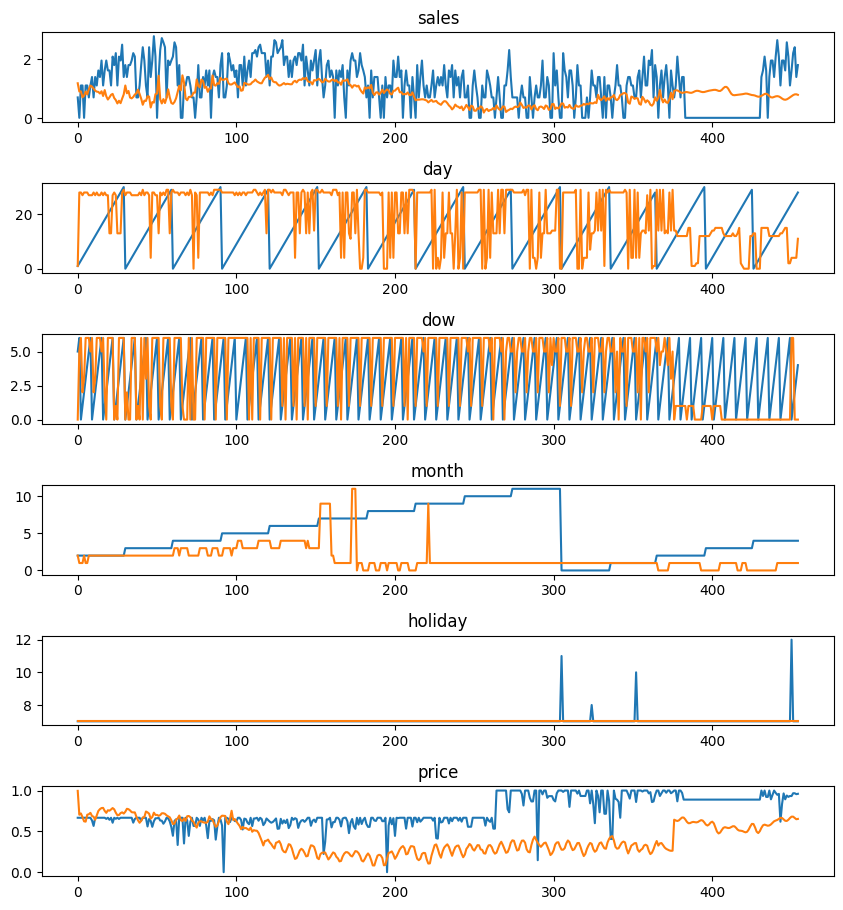

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        output, _ = model(data, remain_rto, device)

    idx = 0
    plt.figure(figsize=(25,15))
    nrows, ncols = 10, 3
    plot_idx = 1
    clear_output(wait=True)

    # Temporal samples
    masked_idx = data["sales_masked_idx"]
    print(masked_idx)
    for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
        plot_idx += 1
        # Sample
        plot_idx += 1
        plt.subplot(nrows, ncols, plot_idx)

        valid_len = data[f"{col}_revert_padding_mask"][idx].min(-1).indices
        valid_len = MAX_SEQ_LEN+90 if valid_len==0 else valid_len

        # print(data[col].shape)
        # print(data[col][idx, :, :].shape)
        # print("_"*100)
        y = data[col][idx][:valid_len].squeeze()
        pred = output[col][idx].detach().cpu()[:valid_len].squeeze()
            
        if col in data_info.processing_info["embedding_cols"]:
            pred = torch.argmax(pred, dim=-1)
        
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.title(col)

        # Attention weight
        plot_idx += 1

    
    plt.tight_layout()
    plt.show()
    input()